# Gaussian Process - Numpy on 100 points

Not all the way im afraid.

#### Table of content
1. Define test data
2. Prior distribution
3. Define training data
4. Posterior distribution

In [242]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1 - Define test data

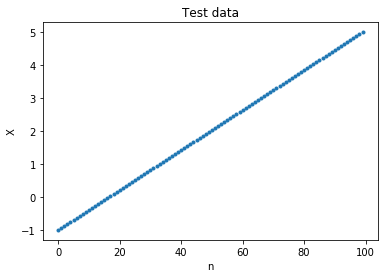

In [372]:
n = 100
X = np.linspace(-1, 5, n)
plt.title('Test data')
plt.plot(X, '.')
plt.xlabel('n')
plt.ylabel('X')
plt.show()

## 2 - Prior distribution

This section will include the following:
* define a squared exponential (SE) kernel function,
* obtain ${\bf K}(x,\,x)$ from the test data,
* draw $k$ standard normally distributed sample distributions,
* scale, (and later on shift), the standard normals with $\sqrt{{\bf K}(x,\,x)}$,
* plot the prior sample distributions, their error intervals, and the test data.

**Some further explanations**

**A:** By prior distribution what we mean is that we are looking for a probability distribution given no other information really than the test data points. The quite arbitrary assumption really, is that this distribution is a scaled standard normal such that:

$$p({\bf f}_{prior} | {\bf X}) = N(0,\bf K)$$

Where $\bf K$ is a co-variance matrix, we will return to this topic later on. For now it is sufficient to say that it is the co-variance of the test data.

**B:** The (SE) kernel function works in two steps:
1. get the squared distances between the variables
2. obtain a measurement of similarity

$${\bf K}(x,\,x^*) = \exp \bigg[-\begin{pmatrix}\frac{\|x - x^*\|}{2\sigma^2}\end{pmatrix}^2 \bigg]$$

Where $x$ is the test data and $x^*$ is the training data even though for now we will only deal with test data, and where $\sigma^2$ is a hypermarameter.


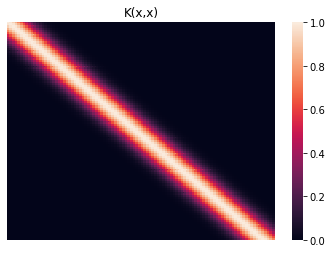

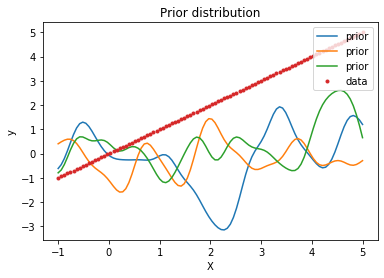

In [374]:
# Radial basis kernel
def kernel(a, b, l=0.1):
    return np.exp(-.5 * 1/l * (np.subtract.outer(a, b)**2))
    
# Co-variance matrix K(x,x) from test data
K = kernel(X, X)
plt.title('K(x,x)')
sns.heatmap(K, cbar=True)
plt.yticks([])
plt.xticks([])
plt.show()
# Draw k standard normal distributions of size n
k = 3
sample_standard = np.random.normal(size=(n, k))
# Get square root of K via a choelsky decomposition
L = np.linalg.cholesky(K + 1e-15 * np.eye(n))
# Scale the standard sample with the covariance information to obtain the prior
prior = np.matmul(L, sample_standard)
# Get the standard deviation
std = np.sqrt(np.diag(K))
plt.title('Prior distribution')
plt.plot(X, prior, label='prior')
#plt.plot(X, sample_standard[:,:1], label='standard normal')
#plt.fill_between(X, -2*std, 2*std, color='#dddddd')
plt.plot(X, X, '.', label='data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.show()

## 3 - Define training data



[1.90909091 2.03030303]


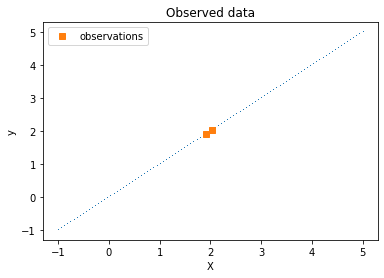

In [383]:
X_train = np.array([X[48], X[50]]) # observations - input space - input values x
Y_train = X_train # observations - feature space - output values f(x)
print(X_train)
plt.title('Observed data')
plt.plot(X, X, ',')
plt.plot(X_train, Y_train, 's', label='observations')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

## 4 - Posterior distribution

Here is what we are going to do:

* define co-variance matrices,
* calculate a predicted mean and an updated sigma,
* draw k standard normal distributions of length n,
* scale and shift the standard normal,
* plot distributions and error boundary

**Some further explanations**

**C:** About the posterior distribution. What one is looking to achieve here is the formulation of a probability distribution in which one is taking into account information from the prior on the one hand, and information from observations on the other hand. With this on hand one can then go about to make predictions as to the distribution of the data. The posterior can be described as follows:

$$p(f_{posterior} | X, f, x^*) = N\sim \begin{pmatrix}\, (\mu(x, x^*), \begin{pmatrix}{\bf K}_{x,x} & {\bf K}_{x,x^*} \\ {\bf K}_{x^*,x} & {\bf K}_{x^*x^*}\end{pmatrix}\end{pmatrix}$$

Where:
* $x,\,f \in \mathbb R^n$ is an $n$ dimensional input features vector, and an output values vector of the training data set  respectively. 
* $x^*,\,f^* \in \mathbb R^m$ is an $m$ dimensional input features vector, and an output distribution vector of the target respectively.
* ${\bf K}_{x,x} \in \mathbb R^{n\,x\,n}$ is the $n\,x\,n$ dimensional co-variance matrix of training points.
* ${\bf K}_{x^*,x} \in \mathbb R^{m\,x\,n}$ is the $m\,x\,n$ dimensional co-variance matrix between each test and training point.
* ${\bf K}_{x^*,x^*} \in \mathbb R^{m\,x\,m}$ is the $m\,x\,m$ dimensional co-variance matrix between testpoints.

**D:** The main equations in this process describe the updates of the mean function and the co-variance function. These can be expressed by the following:

$\mu(f^*) = \mathbb E [f^*|X,f,X^*] = {\bf K}(X^*,X)[{\bf K}(X,X) + \sigma^2_n I]^{-1}f$

$cov(f^*) = {\bf K}(X^*,X^*) - {\bf K}(X^*,X)[{\bf K}(X,X) + \sigma^2_n]^{-1}{\bf K}(X^*,X)^T$

Where the $\sigma^2_n$ is a noise term. Note furthermore the co-variance inverse appearing in both equations. This can be considered as the core computation of this Bayesean update and we will have reason come to this ahead.

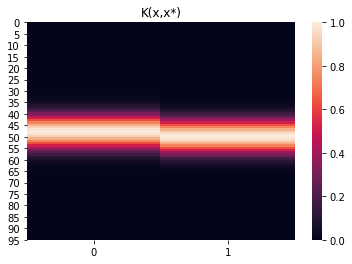

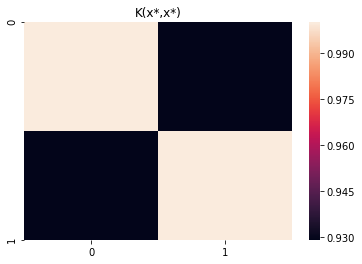

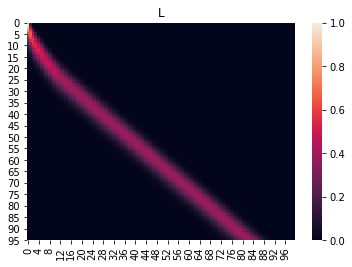

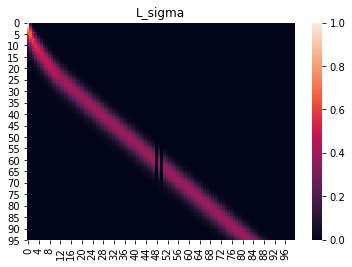

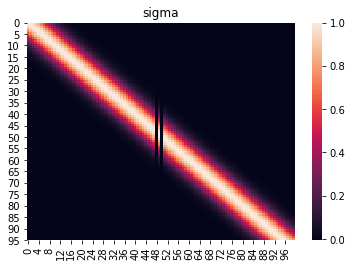

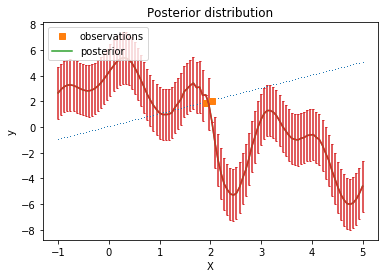

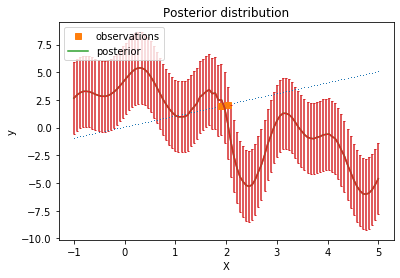

In [419]:
# Define co-variances matrices
Kx = kernel(X, X_train)
Kxx = kernel(X_train, X_train)
plt.title('K(x,x*)')
sns.heatmap(Kx, cbar=True)
plt.show()
plt.title('K(x*,x*)')
sns.heatmap(Kxx, cbar=True)
plt.show()
# Calculate updated mean and sigma
y_pred = np.matmul(np.matmul(Kx.T, np.linalg.inv(K + 1e-15*np.eye(n))).T, Y_train)
updated_sigma = Kxx - np.matmul(np.matmul(Kx.T, np.linalg.inv(K + 1e-15*np.eye(n))), Kx)
# Draw standard normal distributions
k = 1
sample_standard = np.random.normal(size=(n, k))
# Scale and shift
sigma = np.zeros(n)
ones = np.ones(n)
sigma_ones = np.ones(n)
for ind_train, x_train in enumerate(X_train):
    for ind_test, x_test in enumerate(X):
        if x_train == x_test:
            sigma[ind_test] = np.diag(updated_sigma)[ind_train]
            ones[ind_test] = 0
            sigma_ones[ind_test] = np.diag(updated_sigma)[ind_train]
sigma = np.matmul(K, ones*np.eye(n)) + sigma*np.eye(n)
L = np.linalg.cholesky(K + 1e-15 * np.eye(n))
plt.title('L')
sns.heatmap(L, cbar=True)
plt.show()
L_sigma = np.matmul(L, sigma_ones*np.eye(n))
plt.title('L_sigma')
sns.heatmap(L_sigma, cbar=True)
plt.show()
posterior = np.matmul(sigma, sample_standard) + y_pred.reshape(-1, 1)
plt.title('sigma')
sns.heatmap(sigma, cbar=True)
plt.show()
plt.title('Posterior distribution')
plt.plot(X, X, ',')
plt.plot(X_train, Y_train, 's', label='observations')
plt.plot(X, posterior, label='posterior')
plt.errorbar(X, posterior[:,:1], yerr=np.diag(2*sigma**2), capsize=1)
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

plt.title('Posterior distribution')
plt.plot(X, X, ',')
plt.plot(X_train, Y_train, 's', label='observations')
plt.plot(X, posterior, label='posterior')
plt.errorbar(X, posterior[:,:1], yerr=2*np.matmul(np.diag(L_sigma), np.ones(n))**2, capsize=1)
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()